In [28]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline


# Vanilla LSTM 

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction

In [2]:
df = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Text(0.5, 1.0, 'Number of ham and spam messages')

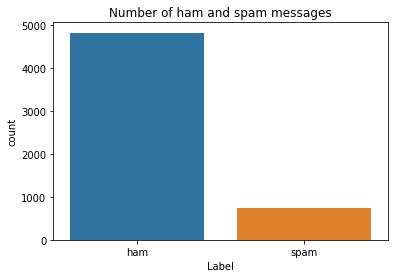

In [3]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [4]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [6]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [7]:
def RNN():
    inp = Input(shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inp)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inp,outputs=layer)
    return model

In [8]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [9]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 20s 5ms/sample - loss: 0.3368 - accuracy: 0.8598 - val_loss: 0.1921 - val_accuracy: 0.9831
Epoch 2/10
3788/3788 [==============================] - 15s 4ms/sample - loss: 0.0874 - accuracy: 0.9802 - val_loss: 0.0445 - val_accuracy: 0.9810
Epoch 3/10
3788/3788 [==============================] - 29s 8ms/sample - loss: 0.0459 - accuracy: 0.9884 - val_loss: 0.0483 - val_accuracy: 0.9821


In [10]:
#Process the test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [11]:
#Evaluate the model
accr = model.evaluate(test_sequences_matrix,Y_test)

836/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [12]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.056
  Accuracy: 0.983


In [33]:
y_pred = model.predict(test_sequences_matrix)
pr, rc, thresholds = precision_recall_curve(Y_test, y_pred)
crossover_index = np.max(np.where(pr <= rc))
crossover_cutoff = thresholds[crossover_index]
m_confusion_test = confusion_matrix(Y_test, y_pred > crossover_cutoff)

In [34]:
print(classification_report(Y_test, y_pred>crossover_cutoff))

display(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       730
           1       0.94      0.93      0.94       106

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.96       836
weighted avg       0.98      0.98      0.98       836



,Predicted 0,Predicted 1
Actual 0,724,6
Actual 1,7,99


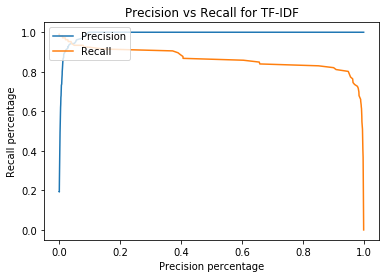

In [35]:
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.xlabel("Precision percentage")
plt.ylabel("Recall percentage")
plt.title("Precision vs Recall for TF-IDF")
plt.legend(['Precision','Recall'], loc='upper left')
plt.show()